In [1]:
import sys
from pathlib import Path, PureWindowsPath
current_folder = PureWindowsPath(globals()['_dh'][0]).as_posix()
path_root = "/".join(current_folder.split("/")[:-3]) #remonter au dossier root du projet
os.chdir(path_root)
print(os.getcwd())
sys.path.append(os.getcwd() + "/sources/classification/")

c:\Users\eupho\OneDrive\Documents\perso\projets\classification_texte_bapteme_philo


In [22]:
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, cross_val_score 
from gensim.utils import tokenize
from pathlib import Path, PureWindowsPath
from lib_classification import *
pd.set_option('display.max_colwidth', 30)
pd.set_option('display.min_rows', 5)
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_colwidth', None) #afficher texte entier dans dataframe

In [3]:
path = PureWindowsPath(os.getcwd() + "/data/input/data_philosophy_baptism.parquet")
path = path.as_posix() #convertir en path linux (convertir les \\ en /)
corpus = pd.read_parquet(path) #engine="fastparquet"
corpus = get_balanced_binary_dataset(corpus, class_col_name="category")

print(corpus["category_bin"].value_counts())
print("presence de doublons ?")
print(corpus.id.duplicated().any())
print(corpus.index.duplicated().any())
corpus

1    1833
0    1833
Name: category_bin, dtype: int64
presence de doublons ?
False
False


,id,message,message_preprocessed,category,length,category_bin
0,0,"Il distingue trois façon de réaliser une unité de nature, toutes impossibles ou inadaptées pour l’Incarnation.",distingue trois façon réaliser unité nature toutes impossible inadaptées incarnation,philosophy,110,1
1,1,"Ici, nous voyons qu’Augustin sait distinguer la substance de l’administration, pour parler en termes réformés, puisqu’il reconnait que tous les baptisés ne sont pas des nôtres. Il sait dire que parmi ceux qui reçoivent les sacrements (administration), certains sont « des nôtres » (de la substance) et d’autre non. Ils se comportent différemment des vrais croyants face à l’épreuve parce qu’ils sont de la paille et non du grain : leur nature différente explique leur réaction différente;",ici voyons augustin sait distinguer substance administration parler terme réformé reconnait tous baptisé nôtre sait dire parmi ceux reçoivent sacrement administration certain « nôtre » substance autre non comportent différemment vrai croyant face épreuve parce paille non grain nature différente explique réaction différente,baptism,488,0
...,...,...,...,...,...,...
3664,3664,"C’est de cette deuxième façon que Dieu a en lui toutes les perfections. **Il n’a pas en lui la blancheur de la neige ou la dureté du roc, mais il a et il donne l’existence à la neige et au roc, qui ensuite ont leur perfections propres**. Sans Dieu pas de neige, pas de roc, et donc pas de blancheur ni de dureté ni le reste des perfections de la création.",cest cette deuxième façon dieu a toutes perfection a blancheur neige dureté roc a donne existence neige roc ensuite perfection propre sans dieu neige roc donc blancheur ni dureté ni reste perfection création,philosophy,355,1
3665,3665,## Article 4: Toute chose est-elle bonne de la Bonté Divine?,article toute chose est-elle bonne bonté divine,philosophy,60,1


In [5]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

In [6]:
tokens = corpus["message_preprocessed"].apply(word_tokenize)
model_skip_gram = Word2Vec(sentences=tokens, vector_size=200,workers=-1, sg=1) #modele skip-gram
model_cbow = Word2Vec(sentences=tokens, vector_size=200,workers=-1, sg=0) #modele CBOW

In [7]:
model = model_skip_gram

In [8]:
model.wv.most_similar("maxime", topn=10)

[('mt', 0.25896257162094116),
 ('pédobaptisme', 0.20739637315273285),
 ('entendre', 0.20565080642700195),
 ('refuser', 0.20269954204559326),
 ('adoptif', 0.20209923386573792),
 ('répondre', 0.19285590946674347),
 ('sauve', 0.19237057864665985),
 ('intéresse', 0.19006812572479248),
 ('excellence', 0.1891028881072998),
 ('matthieu', 0.1874988079071045)]

In [9]:
vocab=list(model.wv.key_to_index.keys())
print(len(vocab))

2924


In [10]:
type(model.wv)
model.wv[0]
model.wv[0].shape

(200,)

In [11]:
model.wv.key_to_index
model.wv.index_to_key[100] #liste de mots
# type(model.wv.index_to_key)

'cas'

In [12]:
model.wv.index_to_key

['dieu',
 '»',
 '«',
 'a',
 'baptême',
 'comme',
 'être',
 'plus',
 'alliance',
 'cette',
 'fait',
 'enfant',
 'si',
 'donc',
 'dit',
 'tout',
 'christ',
 '-',
 '–',
 'foi',
 'bien',
 'chose',
 'cela',
 'peut',
 'homme',
 'non',
 'van',
 'aussi',
 'til',
 'dire',
 'article',
 '…',
 'tous',
 'ainsi',
 'entre',
 'nature',
 'raison',
 'autre',
 'question',
 'parce',
 'car',
 'père',
 'circoncision',
 'faire',
 'personne',
 'sans',
 'grâce',
 'église',
 'baptisé',
 'deux',
 'the',
 'thomas',
 'toute',
 'famille',
 'quand',
 'promesse',
 'autres',
 'alors',
 'baptiste',
 'jésus',
 'chrétien',
 'théologie',
 'sens',
 'vie',
 'selon',
 'fil',
 'réformé',
 'cause',
 'of',
 'encore',
 'effet',
 'nouvelle',
 'acte',
 'testament',
 'ceux',
 'où',
 'point',
 'ici',
 'toutes',
 'péché',
 'avoir',
 'faut',
 'exemple',
 'signe',
 'façon',
 'ancien',
 'lui-même',
 'esprit',
 'volonté',
 'jean',
 'humaine',
 'après',
 'or',
 'doctrine',
 'celui',
 'nouveau',
 'voir',
 'p',
 'grand',
 'monde',
 'cas',
 

In [13]:
len(model.wv.index_to_key)

2924

In [14]:
type(model.wv)

gensim.models.keyedvectors.KeyedVectors

In [15]:
len(words_vectors)
len(words_vectors.index_to_key[:len(words_vectors)])
type(words_vectors[words_vectors.index_to_key[:len(words_vectors)]])
words_vectors[words_vectors.index_to_key[:len(words_vectors)]].shape

NameError: name 'words_vectors' is not defined

In [16]:
words_vectors[words_vectors.index_to_key[:len(words_vectors)]]

NameError: name 'words_vectors' is not defined

In [18]:
#TSNE en 2D apres reduction svd en 50 dimensions
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=30, verbose=1)
tsne_results = tsne.fit_transform(words_vectors_skip_gram[words_vectors_skip_gram.index_to_key[:len(words_vectors_skip_gram)]])
tsne_results

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2924 samples in 0.002s...
[t-SNE] Computed neighbors for 2924 samples in 0.267s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2924
[t-SNE] Computed conditional probabilities for sample 2000 / 2924
[t-SNE] Computed conditional probabilities for sample 2924 / 2924
[t-SNE] Mean sigma: 0.008756
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.476357
[t-SNE] KL divergence after 900 iterations: 3.738301


array([[  7.9785223 , -13.49791   ,   1.2470512 ],
       [-39.20902   ,  17.576405  ,  -7.868293  ],
       [ 38.465553  ,  14.647138  ,   7.6627    ],
       ...,
       [ 27.366573  ,  -0.49108687,   0.6454885 ],
       [-38.73966   ,   9.480808  ,  12.716627  ],
       [-42.971085  ,  13.650212  , -10.092126  ]], dtype=float32)

In [26]:
#Plot 3D de certains mots (car impossible de tous les afficher sinon illisible)
n_kept = 150
import plotly.express as px
fig = px.scatter_3d(corpus, x=tsne_results[0:n_kept,0], y=tsne_results[0:n_kept,1], z=tsne_results[0:n_kept,2],
              text=words_vectors_skip_gram.index_to_key[0:n_kept])
fig.show()

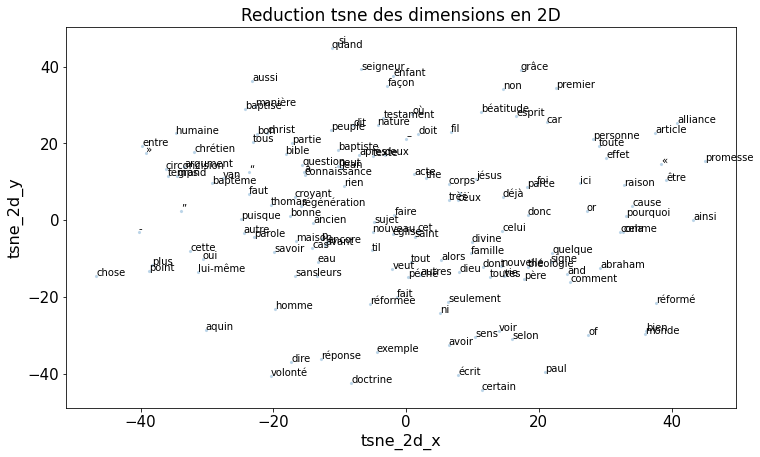

In [27]:
# Sans label
plt.figure(figsize=(12, 7))
sb.scatterplot(
    x=tsne_results[0:n_kept,0], y=tsne_results[0:n_kept,1],
    legend="auto",
    alpha=0.3,
    s=10
)
for i in range(n_kept):
    plt.text(x=tsne_results[i,0], y=tsne_results[i,1], s=words_vectors.index_to_key[i])

plt.xlabel("tsne_2d_x", size=16)
plt.ylabel("tsne_2d_y", size=16)
plt.title("Reduction tsne des dimensions en 2D", size=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [16]:
print(tsne_results[0:50:,0])

[ 32.97364     27.86875      2.6578183   -6.156161    26.759222
  26.850883    16.1331     -18.113335   -18.714615    22.738516
 -17.732666    30.788158   -21.100252    21.00191     40.18455
 -25.64658     11.441761    26.25866     -8.396498    24.155148
   2.2062364  -35.837776   -31.808994    -3.1559381  -15.883595
  11.889427     0.16937323 -17.269344    -4.664543     2.3588793
 -15.474083    14.938675    12.966424    36.691887    32.03494
 -28.764671    14.556421    -5.2187657  -16.172247    -2.6972094
 -24.54941     39.68088     -3.7747867   27.805323    16.432642
  -5.650859    14.336708    -2.8012807   -1.4311023  -29.907084  ]


Utilisation des features word2vec pour la classification

Creation features du modele : moyenne des "mots" d'une phrase

In [68]:
vocab = model.wv.index_to_key
# len(vocab)
# type(vocab)
# print(vocab)
vocab=list(model.wv.key_to_index.keys())
# vocab
type(vocab)

list

In [17]:
words_vectors_skip_gram["alliance"] # vecteur des mots, indice par mot (string)

NameError: name 'words_vectors_skip_gram' is not defined

In [18]:
words_vectors_skip_gram = model_skip_gram.wv
vocab = model_skip_gram.wv.index_to_key
corpus_average_vectors = []
sentence_average_vector = []
sentence_vectors = []
vector_space_dim = 200

for i in range(len(tokens)):
    sentence = tokens[i]
    sentence_words = list(set(vocab) & set(sentence))
    if(sentence_words != []):
        sentence_average_vector = np.mean(words_vectors_skip_gram[sentence_words], axis=0)
        # print("words_vectors_skip_gram[sentence_words] =", words_vectors_skip_gram[sentence_words])
    else:
        print("sentence =", sentence)
        print("sentence_words =", sentence_words)
        sentence_average_vector = np.zeros(vector_space_dim)
    corpus_average_vectors.append(sentence_average_vector)
# print("len(sentence_vectors) =", len(sentence_vectors))
# print("sentence_vectors =", sentence_vectors)
# print("len(sentence_average_vector) =", len(sentence_average_vector))
# len(corpus_average_vectors)
corpus_word2vec_sk = pd.DataFrame(corpus_average_vectors)
corpus_word2vec_sk['id'] = corpus['id']
corpus_word2vec_sk['message'] = corpus['message']
corpus_word2vec_sk["category_bin"] = corpus["category_bin"]
# corpus_word2vec_sk

sentence = ['tortarolohttpssecuregravatarcomavatarbaddffbdfaefbsdmmrg']
sentence_words = []


In [19]:
X = corpus_word2vec_sk.iloc[:, np.r_[0:200]]
y = corpus_word2vec_sk["category_bin"]
indices = corpus["id"]
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.33, random_state=42)

In [14]:
# Cross validation
#Methode version automatisee facile grace a la fonction RepeatedStratifiedKFold de sklearn
#Selection de modeles avec la k cross validation pour determiner le meilleur
#Modeles utilisés dans les papiers :
# LogisticRegression, MultinomialNB (= naive bayes), SVC (SVD petit data), SGDClassifier (SVD grand data)
# DecisionTreeClassifier, RandomForestClassifier
# AdaBoostClassifier, MLPClassifier
pd.set_option("display.precision", 2)
# scoring = ['accuracy', 'precision', 'recall', 'f1', 'f1_macro']
scoring = ['f1_macro', 'f1_micro']
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('AdaBoostClassifier', AdaBoostClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('RandomForest', RandomForestClassifier()))
# models.append(('MLPClassifier', MLPClassifier(max_iter=500))) car diverge donc trop long
models.append(('SGDClassifier', SGDClassifier()))
models.append(('SVM', SVC()))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
 
# evaluate each model in turn
results = []
names = []
num_iter = 6
for name, model in models:
    kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=num_iter, random_state=None)
    cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
    for k, scores in cv_results.items():
        cv_results[k] = round(np.mean(scores), 4) #on fait la moyenne de chaque score (rappel, precision, etc.) pour les k experiences
    print((str(list(cv_results.items())[2:])+" ({0})").format(name)) #2: pour ignorer les info inutiles

[('test_f1_macro', 0.3355), ('test_f1_micro', 0.5033)] (LR)
[('test_f1_macro', 0.7444), ('test_f1_micro', 0.7446)] (AdaBoostClassifier)
[('test_f1_macro', 0.6293), ('test_f1_micro', 0.6621)] (KNN)
[('test_f1_macro', 0.7857), ('test_f1_micro', 0.7858)] (RandomForest)
[('test_f1_macro', 0.3343), ('test_f1_micro', 0.5008)] (SGDClassifier)
[('test_f1_macro', 0.8492), ('test_f1_micro', 0.8493)] (SVM)
[('test_f1_macro', 0.6298), ('test_f1_micro', 0.6302)] (DecisionTreeClassifier)


c:\Users\eupho\OneDrive\Documents\perso\projets\classification_texte_bapteme_philo/sources/classification\lib_classification.py:63: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_xticklabels([false_label, true_label], Fontsize=font_size + 3)
c:\Users\eupho\OneDrive\Documents\perso\projets\classification_texte_bapteme_philo/sources/classification\lib_classification.py:64: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_yticklabels([false_label, true_label], Fontsize=font_size + 3)


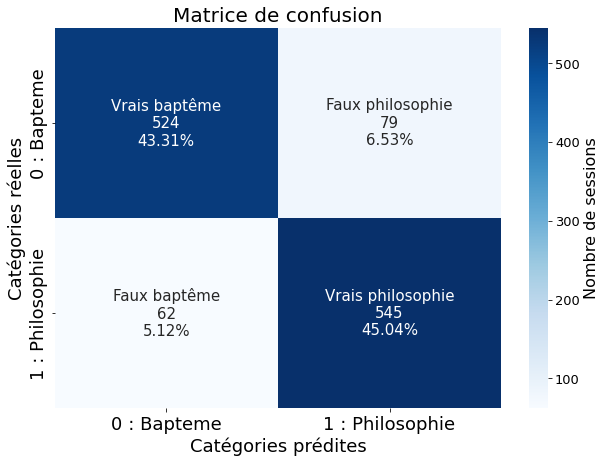

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# model_cbow
model = SVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
get_confusion_matrix(y_test, y_pred, model)

In [24]:
# Metriques
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       603
           1       0.87      0.90      0.89       607

    accuracy                           0.88      1210
   macro avg       0.88      0.88      0.88      1210
weighted avg       0.88      0.88      0.88      1210



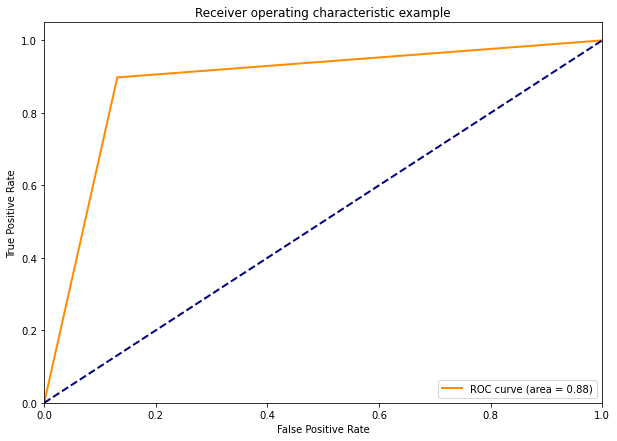

In [25]:
# Courbe ROC et AUC
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

sources :
http://ethen8181.github.io/machine-learning/keras/text_classification/word2vec_text_classification.html

In [26]:
k = 10
# kfold = StratifiedKFold(n_splits=k, random_state=None, shuffle=True) #n_splits = k de la k-fold cv, le nombre de fold
kfold = RepeatedStratifiedKFold(n_splits=k, n_repeats=2, random_state=None)
scoring = 'accuracy'
cv_param = kfold
num_experiences = 10
train_sizes = np.linspace(0.1, 1.0, num_experiences)
# train_sizes = np.linspace(0.001, 1.0, num_experiences)
n_jobs = -1

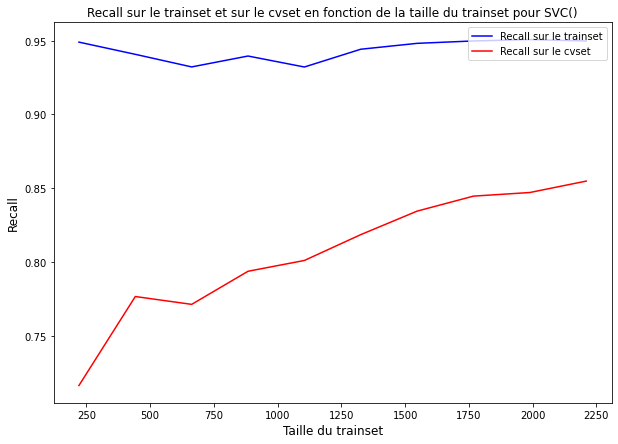

In [28]:
model = SVC() #le meilleur modele garde apres cross validation 
get_learning_curve(model, X_train, y_train, cv_param, "recall", train_sizes, n_jobs)

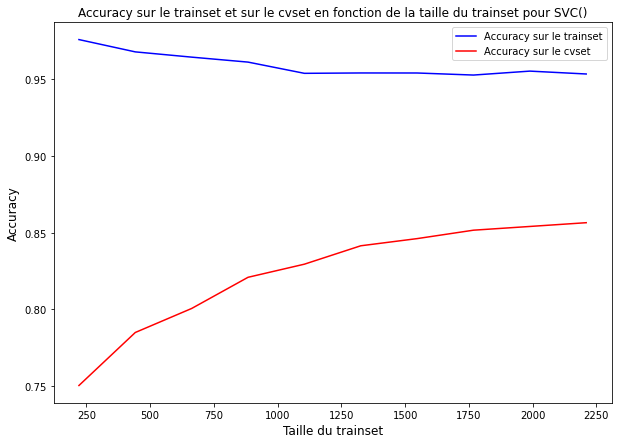

In [29]:
get_learning_curve(model, X_train, y_train, cv_param, "accuracy", train_sizes, n_jobs)

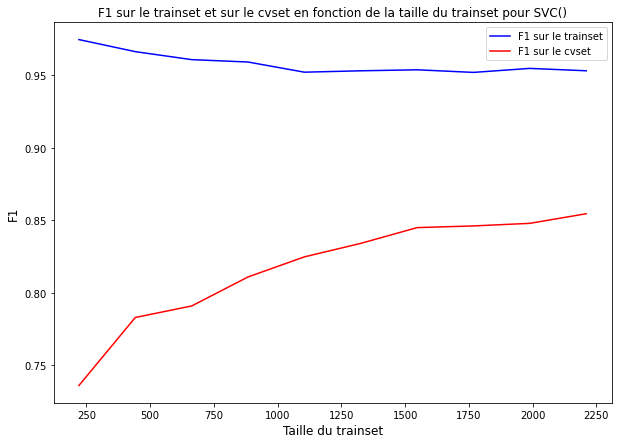

In [30]:
get_learning_curve(model, X_train, y_train, cv_param, "f1", train_sizes, n_jobs)

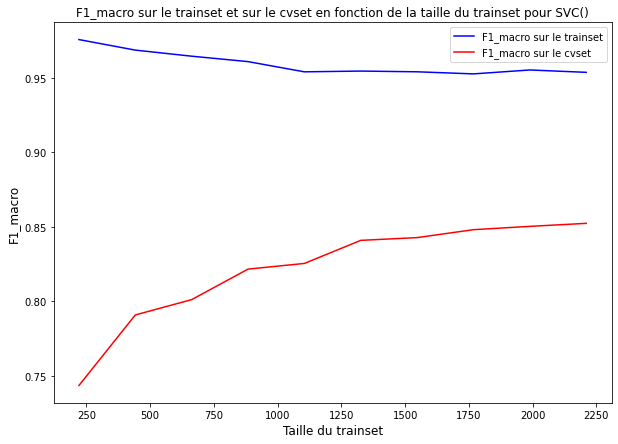

In [31]:
get_learning_curve(model, X_train, y_train, cv_param, "f1_macro", train_sizes, n_jobs)

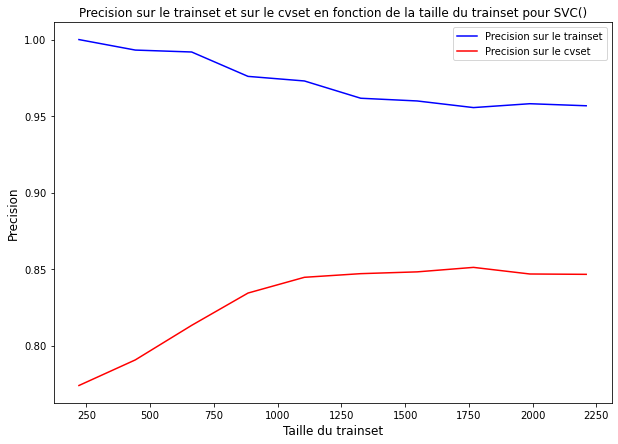

In [32]:
get_learning_curve(model, X_train, y_train, cv_param, "precision", train_sizes, n_jobs)